# Get electricity data from the ENTSO-E API

To run this notebook, you must have the following environment variables set:

* BENTSO_DATA_DIR: Directory to cache data from ENTSO-E API
* ENTSOE_API_TOKEN: API token you get from signing up to ENTSO-E transparency platform

## Get data

In [1]:
from bentso import CachingDataClient as CDC
from entsoe.exceptions import NoMatchingDataError
import time

In [2]:
cdc = CDC()

Using data directory /Users/cmutel/Code/akula/entso-data-cache


In [3]:
from bentso.constants import ENTSO_COUNTRIES, TRADE_PAIRS

In [4]:
for country in ENTSO_COUNTRIES:
    print(country)
    for year in (2019, 2020, 2021):
        success, tries = False, 0
        while not success and tries < 5:
            try:
                cdc.get_generation(country=country, year=year)
                success = True
            except ConnectionError:
                tries += 1
                time.sleep(5)
            except NoMatchingDataError:
                print(f"Can't get data for {country}")
                success=True

FI
SE
CH
PT
BE
BG
HU
GB
FR
LV
DK
IT
ME
AT
MT
Querying ENTSO-E API. Please be patient...
Can't get data for MT
Querying ENTSO-E API. Please be patient...
Can't get data for MT
Querying ENTSO-E API. Please be patient...
Can't get data for MT
NO
SK
ES
RO
NL
MK
PL
HR
LU
Querying ENTSO-E API. Please be patient...
Can't get data for LU
Querying ENTSO-E API. Please be patient...
Can't get data for LU
SI
BA
CZ
DE
EE
GR
IE
RS


In [5]:
for dst, lst in TRADE_PAIRS.items():
    print(dst)
    for src in lst:
        for year in (2018, 2019, 2020, 2021):
            success, tries = False, 0
            while not success and tries < 5:
                try:
                    cdc.get_trade(from_country=src, to_country=dst, year=year)
                    success = True
                except ConnectionError:
                    tries += 1
                    time.sleep(5)
                except:
                    print("Error with:", dst, src, year)
                    success = True

AT
BA
BE
BG
CH
CZ
DE
DK
EE
FI
FR
GB
Querying ENTSO-E API. Please be patient...
Querying ENTSO-E API. Please be patient...
Querying ENTSO-E API. Please be patient...
Querying ENTSO-E API. Please be patient...
Querying ENTSO-E API. Please be patient...
Querying ENTSO-E API. Please be patient...
Querying ENTSO-E API. Please be patient...
Querying ENTSO-E API. Please be patient...
Querying ENTSO-E API. Please be patient...
Querying ENTSO-E API. Please be patient...
Querying ENTSO-E API. Please be patient...
Querying ENTSO-E API. Please be patient...
GR
HR
Querying ENTSO-E API. Please be patient...
Error with: HR BG 2018
Querying ENTSO-E API. Please be patient...
Error with: HR BG 2019
Querying ENTSO-E API. Please be patient...
Error with: HR BG 2020
Querying ENTSO-E API. Please be patient...
Error with: HR BG 2021
HU
IT
LU
Querying ENTSO-E API. Please be patient...
Error with: LU FR 2018
Querying ENTSO-E API. Please be patient...
Error with: LU FR 2019
Querying ENTSO-E API. Please be patie

# Errors

We don't have generation data for Luxembourg or Malta. We will just leave the existing ecoinvent values for these countries.

We don't have trade from Bulgaria to Croatia, but this is small ($10^{-5}$), so we can ignore it.

We don't have trade from Russia to Norway, but this is small ($10^{-4}$), so we can ignore it.

We don't have trade from Morocco to Spain, but this is small ($10^{-4}$), so we can ignore it.

## Get generation types

In [14]:
gt = set([])

for country in ENTSO_COUNTRIES:
    df = cdc.get_generation(country=country, year=2020)
    for obj in df.columns:
        if isinstance(obj, tuple):
            gt.add(obj[0])
        else:
            gt.add(obj)

In [15]:
gt

{'Biomass',
 'Fossil Brown coal/Lignite',
 'Fossil Coal-derived gas',
 'Fossil Gas',
 'Fossil Hard coal',
 'Fossil Oil',
 'Fossil Oil shale',
 'Fossil Peat',
 'Geothermal',
 'Hydro Pumped Storage',
 'Hydro Run-of-river and poundage',
 'Hydro Water Reservoir',
 'Marine',
 'Nuclear',
 'Other',
 'Other renewable',
 'Solar',
 'Waste',
 'Wind Offshore',
 'Wind Onshore'}

# Graph sources

In [51]:
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt

In [34]:
df = cdc.get_generation(country='DE', year=2019)

In [35]:
df = df.drop(labels=[
    (                     'Fossil Gas', 'Actual Consumption'),
    ('Fossil Oil', 'Actual Consumption'),
    (           'Hydro Pumped Storage', 'Actual Consumption'),
    (                        'Nuclear', 'Actual Consumption'),
    (          'Hydro Water Reservoir', 'Actual Consumption'),
], 
    axis=1
)

In [36]:
df.columns = df.columns.droplevel(level=1)

In [37]:
df['Wind'] = df['Wind Offshore'] + df['Wind Onshore']
df['Coal'] = df['Fossil Brown coal/Lignite'] + df['Fossil Hard coal']
df['Gas'] = df['Fossil Gas']
df['Hydro'] = df['Hydro Run-of-river and poundage'] + df['Hydro Water Reservoir']

In [38]:
df = df.drop(labels=['Hydro Pumped Storage', 'Wind Onshore', 'Wind Offshore', 
                     'Fossil Brown coal/Lignite', 'Fossil Hard coal', 'Fossil Gas',
                     'Hydro Run-of-river and poundage', 'Hydro Water Reservoir'], axis=1)

In [39]:
df['Total'] = df.sum(axis=1)

In [40]:
for column in df.columns:
    if column != 'Total':
        df[column] = df[column] / df['Total']

In [41]:
df.columns

Index(['Biomass', 'Fossil Coal-derived gas', 'Fossil Oil', 'Geothermal',
       'Nuclear', 'Other', 'Other renewable', 'Solar', 'Waste', 'Wind', 'Coal',
       'Gas', 'Hydro', 'Total'],
      dtype='object')

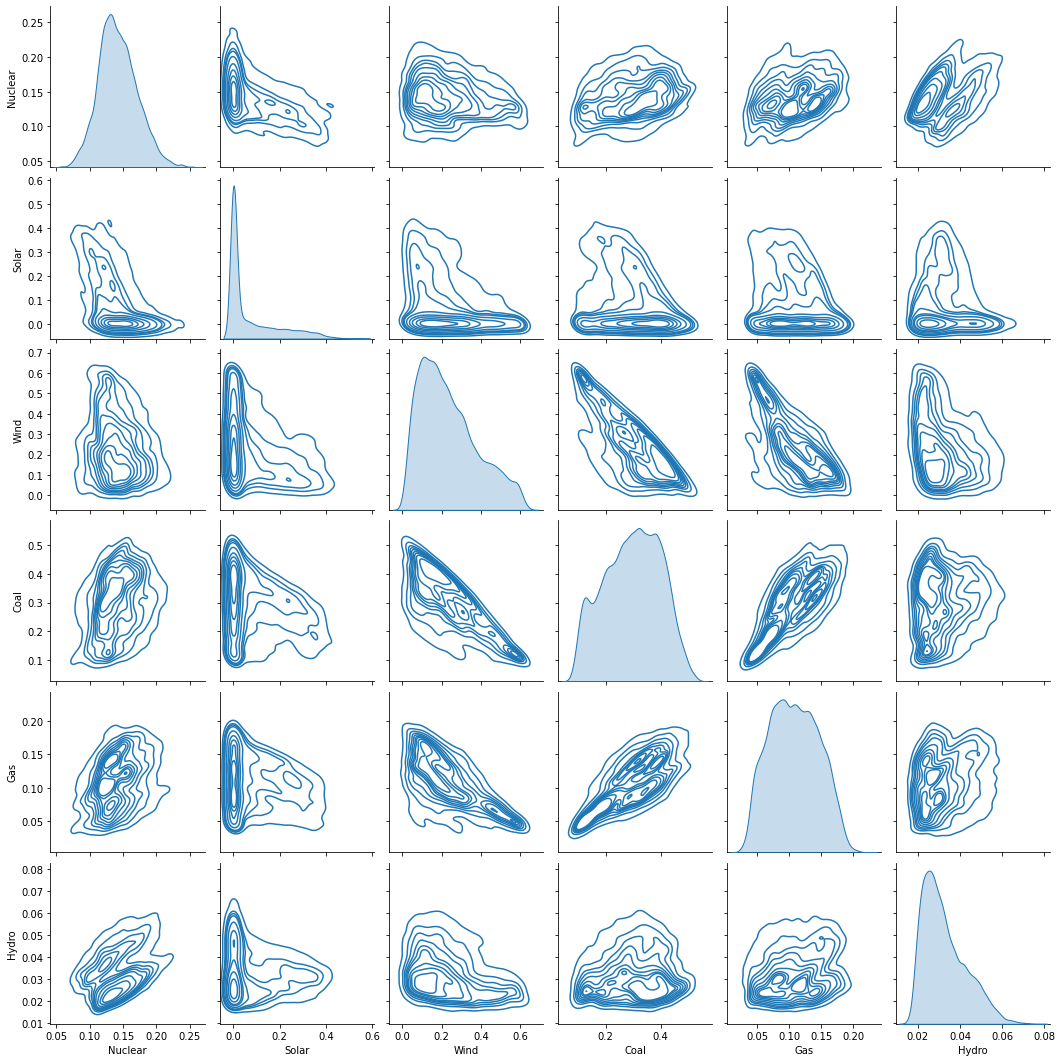

In [53]:
sb.pairplot(df[['Nuclear', 'Solar', 'Wind', 'Coal', 'Gas', 'Hydro']], kind='kde')

In [55]:
plt.savefig("de-2019-kde.png", dpi=300)

<Figure size 432x288 with 0 Axes>